fit 里面设置权重

In [1]:
seed = 0
import random
import tensorflow as tf
import numpy as np
import os
random.seed(seed),
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["PYTHONHASHSEED"] = str(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
import numpy as np
import pandas as pd
# 选择比较好的模型
# import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import resample
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
# %load_ext autoreload
# %autoreload 2


def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0


sample_num = 60

In [4]:
!ls ../../

data			      ensemble_2_to_0806allin088716.py	PKL
ensemble_1_to_allin088681.py  lgb_emsemble


In [5]:
root_path  = '../../data/'
train = pd.read_csv(root_path+'sensor_train.csv')
test = pd.read_csv(root_path+'sensor_test.csv')
sub = pd.read_csv(root_path+'提交结果示例.csv')
y = train.groupby('fragment_id')['behavior_id'].min()

In [6]:
def add_features(df):
    print(df.columns)
    df['acc'] = (df.acc_x ** 2 + df.acc_y ** 2 + df.acc_z ** 2) ** .5
    df['accg'] = (df.acc_xg ** 2 + df.acc_yg ** 2 + df.acc_zg ** 2) ** .5
    df['thetax']=np.arctan(df.acc_xg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetay']=np.arctan(df.acc_yg/
                           np.sqrt(df.acc_xg*df.acc_xg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetaz']=np.arctan(df.acc_zg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_xg*df.acc_xg))*180/np.pi

    df['xy'] = (df['acc_x'] ** 2 + df['acc_y'] ** 2) ** 0.5
    df['xy_g'] = (df['acc_xg'] ** 2 + df['acc_yg'] ** 2) ** 0.5    
    
    df['g'] = ((df["acc_x"] - df["acc_xg"]) ** 2 + 
                 (df["acc_y"] - df["acc_yg"]) ** 2 + (df["acc_z"] - df["acc_zg"]) ** 2) ** 0.5

    print(df.columns)
    return df

In [7]:
train=add_features(train)
test=add_features(test)

Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id', 'acc', 'accg', 'thetax', 'thetay',
       'thetaz', 'xy', 'xy_g', 'g'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'acc', 'accg', 'thetax', 'thetay', 'thetaz', 'xy',
       'xy_g', 'g'],
      dtype='object')


In [8]:
group1 = [x for x in train.columns if x not in ['fragment_id', 'time_point','behavior_id']]
group1

['acc_x',
 'acc_y',
 'acc_z',
 'acc_xg',
 'acc_yg',
 'acc_zg',
 'acc',
 'accg',
 'thetax',
 'thetay',
 'thetaz',
 'xy',
 'xy_g',
 'g']

In [9]:
FEATURE_NUM=14

In [10]:

x = np.zeros((7292, sample_num, FEATURE_NUM, 1))
t = np.zeros((7500, sample_num, FEATURE_NUM, 1))


In [11]:

train = train[['fragment_id', 'time_point', 'behavior_id']+group1]
test = test[['fragment_id', 'time_point']+group1]
print(train.columns)

for i in tqdm(range(7292)):
    tmp = train[train.fragment_id == i][:sample_num]
    x[i,:,:,0] = resample(tmp.drop(['fragment_id', 'time_point', 'behavior_id'],
                                    axis=1)[group1], sample_num, np.array(tmp.time_point))[0].reshape(sample_num,FEATURE_NUM)
for i in tqdm(range(7500)):
    tmp = test[test.fragment_id == i][:sample_num]
    t[i,:,:,0] = resample(tmp.drop(['fragment_id', 'time_point'],
                                    axis=1)[group1], sample_num, np.array(tmp.time_point))[0].reshape(sample_num,FEATURE_NUM)

    
    

  1%|          | 47/7292 [00:00<00:15, 462.73it/s]

Index(['fragment_id', 'time_point', 'behavior_id', 'acc_x', 'acc_y', 'acc_z',
       'acc_xg', 'acc_yg', 'acc_zg', 'acc', 'accg', 'thetax', 'thetay',
       'thetaz', 'xy', 'xy_g', 'g'],
      dtype='object')


100%|██████████| 7500/7500 [00:15<00:00, 474.36it/s]


In [12]:
def ConvBNRelu(X,filters,kernal_size=(3,3)):
    X = Conv2D(filters=filters,
               kernel_size=kernal_size,
#                activation='relu',
               use_bias=False,
               padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    return X


def ConvRelu(X,filters,kernal_size=(3,3)):
    X = Conv2D(filters=filters,
               kernel_size=kernal_size,
               activation='relu',
               use_bias=False,
               padding='same')(X)
    return X


def squeeze_excitation_layer(x, out_dim,ratio=8):
    '''
    SE module performs inter-channel weighting.
    '''
    squeeze = GlobalAveragePooling2D()(x)

    excitation = Dense(units=out_dim // ratio)(squeeze)
    excitation = Activation('relu')(excitation)
    excitation = Dense(units=out_dim)(excitation)
    excitation = Activation('sigmoid')(excitation)
    excitation = Reshape((1,1,out_dim))(excitation)
    scale = multiply([x,excitation])
    return scale

# def SE_Residual(X):
#     A = 
#     X = squeeze_excitation_layer(X,128)
#     X =  Add()([X,A])
    

def lenet5(input):
    A = ConvBNRelu(input,64,kernal_size=(3,3))
#     B = ConvBNRelu(input,16,kernal_size=(5,1))
#     C = ConvBNRelu(input,16,kernal_size=(7,1))
#     ABC = layers.Concatenate()([A,B,C])
    X = ConvBNRelu(A,128)
#     X = squeeze_excitation_layer(X,128)
    X = Dropout(0.2)(X)

    X = AveragePooling2D()(X)
    
    X = ConvBNRelu(X,256)
    X = Dropout(0.3)(X)
#     X = squeeze_excitation_layer(X,256)
    X = ConvBNRelu(X,512)   
    X = Dropout(0.5)(X)
#     X = squeeze_excitation_layer(X,512)
#     X = GlobalMaxPooling2D()(X)
    X = GlobalAveragePooling2D()(X)
    
#     X = BatchNormalization()(X)
    return X
import tensorflow as tf
def Net(sample_num):
    input1 = Input(shape=(sample_num, FEATURE_NUM, 1))
    part = tf.split(input1,axis=2, num_or_size_splits = [6, 2, 6])
#     res = tf.split(c, axis = 3, num_or_size_splits = [2, 2, 4])
    
    
    X1 = Concatenate(axis=-2)([part[0],part[1]])
    X1 = lenet5(X1)
    X1 = BatchNormalization()(X1)
    X1 = Dense(128, activation='relu')(X1)
    X1 = BatchNormalization()(X1)
    X1 = Dropout(0.2)(X1)

    X2 = Concatenate(axis=-2)([part[0],part[2]])
    X2 = lenet5(X2)    
    X2 = BatchNormalization()(X2)
#     X = Dense(512, activation='relu')(X)
#     X = BatchNormalization()(X)
    X2 = Dense(128, activation='relu')(X2)
    X2 = BatchNormalization()(X2)
    X2 = Dropout(0.2)(X2)
    
    X = Concatenate(axis=-1)([X1,X2])
    
#     X = Dense(19)(X)    
    
    O = Dense(19, activation='softmax')(X)    
    
    
    return Model([input1], O)

model = Net(60)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 14, 1)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_split (TensorFlowOp [(None, 60, 6, 1), ( 0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60, 8, 1)     0           tf_op_layer_split[0][0]          
                                                                 tf_op_layer_split[0][1]          
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 60, 12, 1)    0           tf_op_layer_split[0][0]      

In [18]:
from sklearn.utils.class_weight import compute_class_weight
# y_train_weight = compute_sample_weight("balanced", train['behavior_id'])
classweights=compute_class_weight("balanced",np.array(range(19)), train['behavior_id'])
classweights=pd.DataFrame(classweights)[0].to_dict()
classweights

{0: 1.6146639588513296,
 1: 0.5658077637797579,
 2: 0.9428223116223914,
 3: 1.1544614165363905,
 4: 0.895063001338305,
 5: 1.120093850476494,
 6: 0.5129293816036677,
 7: 1.6147804233607677,
 8: 1.1629774436090226,
 9: 1.3287818013695207,
 10: 1.639495846903968,
 11: 0.8571276001942526,
 12: 0.5209381219191084,
 13: 1.3164363042146117,
 14: 3.1705588145409553,
 15: 0.8020390423628304,
 16: 1.108447580802777,
 17: 1.4649467209444893,
 18: 1.12076674790857}

In [19]:
# [:,:,:,[1]]
train = x
test = t


def label_smooth(y,rate=0.05):
    y = y * (1 - rate)
    y = y + rate / 19
    return y
    
fold_num=5
kfold = StratifiedKFold(fold_num,random_state=42,shuffle=True)
proba_t = np.zeros((7500, 19))
proba_oof = np.zeros((7292,19))

oof_score = []
oof_comm = []
history = []
for fold, (xx, yy) in enumerate(kfold.split(train, y)):
    y_ = to_categorical(y, num_classes=19)
    y_ = label_smooth(y_)
    model = Net(60)
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=["acc"])#'',localscore
    plateau = ReduceLROnPlateau(monitor="acc",
                                verbose=1,
                                mode='max',
                                factor=0.5,
                                patience=18)
    early_stopping = EarlyStopping(monitor="val_acc",
                                   verbose=1,
                                   mode='max',
                                   patience=60)

    checkpoint = ModelCheckpoint(f'Conv2dfold{fold}.h5',
                                 monitor="val_acc",
                                 verbose=0,
                                 mode='max',
                                 save_best_only=True)
 
    train_res = model.fit(train[xx], y_[xx],
              epochs=1000,
              batch_size=32,
              verbose=1,
              shuffle=True,
              validation_data=(train[yy], y_[yy],),
              callbacks=[plateau, early_stopping, checkpoint],
              class_weight=classweights)
    history.append(train_res)
    
 
    model.load_weights(f'Conv2dfold{fold}.h5')
    proba_t += model.predict(test, verbose=0, batch_size=1024) / fold_num 
    proba_oof[yy] += model.predict(train[yy],verbose=0,batch_size=1024) 

    oof_y = np.argmax(proba_oof[yy], axis=1)
    acc = round(accuracy_score(y[yy], oof_y),3)
    print(acc)
    oof_score.append(acc)
    scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(y[yy], oof_y)) / oof_y.shape[0]
    oof_comm.append(scores)   
    print(round(scores, 5))


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 14, 1)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_split_1 (TensorFlow [(None, 60, 6, 1), ( 0           input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 60, 8, 1)     0           tf_op_layer_split_1[0][0]        
                                                                 tf_op_layer_split_1[0][1]        
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 60, 12, 1)    0           tf_op_layer_split_1[0][0]  

  ...
    to  
  ['...']
Train on 5833 samples, validate on 1459 samples
Epoch 1/1000
5833/5833 [==============================] - 9s 2ms/sample - loss: 2.3558 - acc: 0.2633 - val_loss: 2.6321 - val_acc: 0.2536
Epoch 2/1000
2816/5833 [=============>................] - ETA: 2s - loss: 2.0178 - acc: 0.3452WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc,lr


KeyboardInterrupt: 

In [ ]:
# import matplotlib.pyplot as plt   
# plt.figure(figsize=(12,20))
# start=5
# for i in range(5):
#     min_acc_index=history[i].history['val_loss'].index(np.min(history[i].history['val_loss']))
#     print(str(i)+' val_loss'+str(history[i].history['val_loss'][min_acc_index])+'val_acc'+str(history[i].history['val_acc'][min_acc_index]))
# for i in range(5):
#     min_acc_index=history[i].history['val_loss'].index(np.min(history[i].history['val_loss']))
#     length=len(history[i].history['loss'][start:])
#     plt.subplot(5,1,i+1)
#     plt.plot(range(length),history[i].history['loss'][start:],label='loss')
#     plt.plot(range(length),history[i].history['acc'][start:],label='acc')
#     plt.plot(range(length),history[i].history['val_loss'][start:],label='val_loss')
#     plt.plot(range(length),history[i].history['val_acc'][start:],label='val_acc')
#     plt.title(str(i)+' val_loss'+str(history[i].history['val_loss'][min_acc_index])+'val_acc'+str(history[i].history['val_acc'][min_acc_index]))
#     plt.legend(loc='best')
    
# print(oof_score,np.mean(oof_score))
# print(oof_comm,np.mean(oof_comm))

In [49]:
for index,i in enumerate(oof_comm):
    print(index,i,oof_score[index])

oof_dict = {
    "oof":proba_oof,
    "test":proba_t,
    "acc":oof_comm,
}
import joblib 
joblib.dump(oof_dict,"0725_conv2_2_net_weight_comm_%.5f_dict.pkl"% np.mean(oof_comm))


0 0.8668363849995089 0.845
1 0.8334802049675238 0.803
2 0.8686720229930087 0.845
3 0.8404859886341358 0.811
4 0.8689006466784225 0.848


['0725_conv2_2_net_weight_comm_0.85568_dict.pkl']

0.83036
0.85567


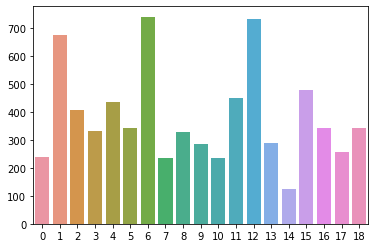

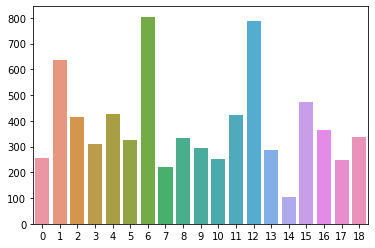

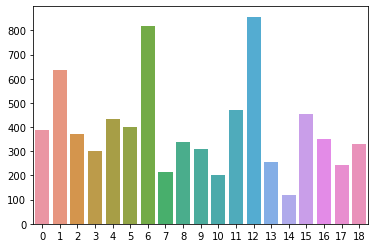

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   fragment_id  7500 non-null   int64
 1   behavior_id  7500 non-null   int64
dtypes: int64(2)
memory usage: 117.3 KB


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

train_y = y
labels = np.argmax(proba_t, axis=1)
oof_y = np.argmax(proba_oof, axis=1)
print(round(accuracy_score(train_y, oof_y), 5))
scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(scores, 5))
data_path = '../../zp/jiaozibei/data/'
sub = pd.read_csv(data_path+'提交结果示例.csv')
sub['behavior_id'] = labels

vc = pd.Series(train_y).value_counts().sort_index()
# sns.barplot(vc.index, vc.values)
# plt.show()

vc = pd.Series(oof_y).value_counts().sort_index()
# sns.barplot(vc.index, vc.values)
# plt.show()

vc = sub['behavior_id'].value_counts().sort_index()
# sns.barplot(vc.index, vc.values)
# plt.show()
sub.to_csv('0721_conv2_2_net_oof_comm_nn%.5f.csv' % scores, index=False)
sub.info()


['A_0', 'A_1', 'A_2', 'A_3', 'D_4', 'A_5', 'B_1', 'B_5', 'B_2', 'B_3', 'B_0', 'A_6', 'C_1', 'C_3', 'C_0', 'B_6', 'C_2', 'C_5', 'C_6']


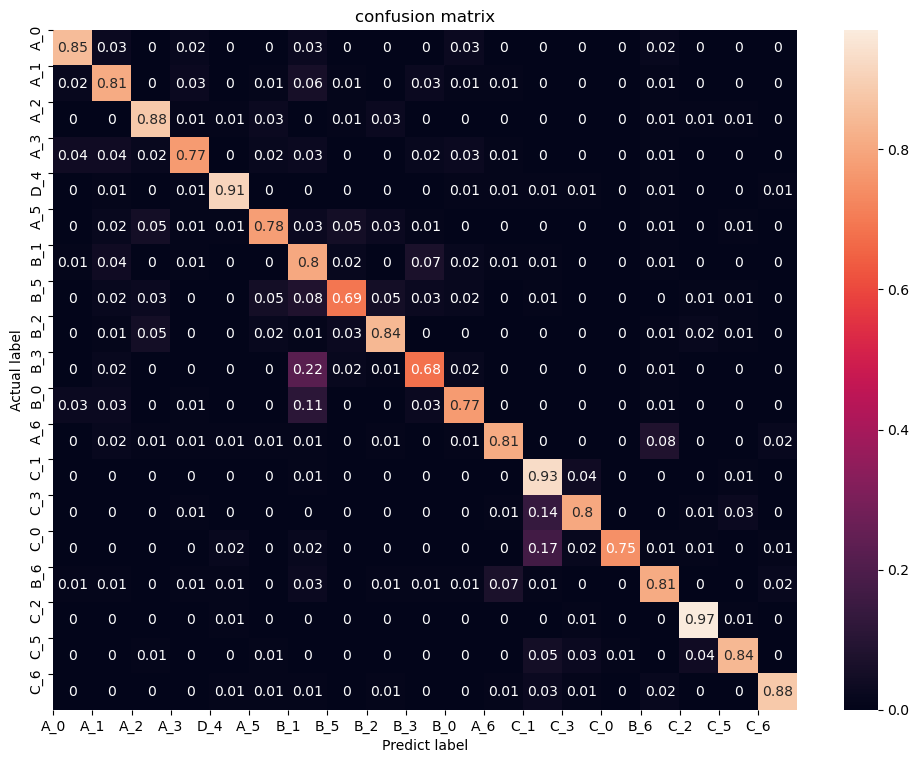

In [51]:

# %matplotlib inline
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_confusion_matrix(cm,classes,title='Confusion Matrix'):

#     plt.figure(figsize=(12, 9), dpi=100)
#     np.set_printoptions(precision=2)
    
#     sns.heatmap(cm,annot=True)
#     plt.title(title)
#     plt.xticks(ticks=range(19),labels=classes)
#     plt.yticks(ticks=range(19),labels=classes)
    
#     plt.ylabel('Actual label')
#     plt.xlabel('Predict label')
#     plt.show()
    
# # classes表示不同类别的名称，比如这有6个类别
# num2detail_mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
#         4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
#         8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
#         12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
#         16: 'C_2', 17: 'C_5', 18: 'C_6'}

# classes = [num2detail_mapping[int(i)]for i in range(19)]
# print(classes)
# # 获取混淆矩阵
# cm = confusion_matrix(train_y, oof_y,normalize='true')
# cm = np.round(cm,2)
# plot_confusion_matrix(cm,classes, title='confusion matrix')